<a href="https://colab.research.google.com/github/PlashSpeed-Aiman/AssigmentSubmission/blob/main/1729963Assessment1_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assessment 1: Deep Learning

1) Answer all questions.
2) This assessment is open-book. You are allowed to refer to any references including online materials, books, notes, codes, github links, etc.
3) Copy this notebook to your google drive (click **FILE** > **save a copy in Drive**)
4) Upload the answer notebook to your github. 
5) Submit the assessment by sharing the link to your answer notebook. 





**QUESTION 1** 

One day while wandering around a clothing store at KL East Mall, you stumbled upon a pretty girl who is choosing a dress for Hari Raya. It turns out that the girl is visually impaired and had a hard time distinguishing between an abaya and a kebaya. To help people with the similar situation, you then decided to develop an AI system to identify the type of clothes using a Convolutional Neural Networks (ConvNet). In order to train the network, you decide to use the Fashion MNIST dataset which is freely available on Pytorch.


a) Given the problem, what is the most appropriate loss function to use? Justify your answer. **[5 marks]**


<span style="color:blue;background-color: lightgrey;">
    Cross Entropy. The loss function with minimize the distance between two probability distributions</span>

b) Create and train a ConvNet corresponding to the following CNN architecture (with a modification of the final layer to address the number of classes). Please include **[10 marks]**:

    1) The dataloader to load the train and test datasets.

    2) The model definition (either using sequential method OR pytorch class method).

    3) Define your training loop.

    4) Output the mean accuracy for the whole testing dataset.

    

<div>
<img src="https://vitalflux.com/wp-content/uploads/2021/11/VGG16-CNN-Architecture.png" width="550"/>
</div>


In [ ]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary


###############################################
######## THE REST OF YOUR CODES HERE ##########
###############################################
image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((224,224)),
        transforms.RandomAutocontrast(0.3),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.485],
                             [0.229])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.485],
                             [0.229])
    ])
}

In [ ]:
batch_size = 32
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=image_transforms['train'])
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                        download=True, transform=image_transforms['test'])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)   

60000
10000


In [ ]:
class My_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 224, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(224, 112, 3)
        self.conv3 = nn.Conv2d(112, 56, 3)
        self.conv4 = nn.Conv2d(56,28, 3)
        self.conv5 = nn.Conv2d(28, 14, 3)
        self.conv6 = nn.Conv2d(14, 7, 3)
        self.fc7 = nn.Linear(7* 1*1, 4096)
        self.fc8 = nn.Linear(4096, 1000)
        self.fc9 = nn.Linear(1000, 10)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = self.pool(self.relu(self.conv5(x)))
        x = self.pool(self.relu(self.conv6(x)))
        # print(x.shape)
        x = x.view(-1,7 *1 * 1)
        x = self.relu(self.fc7(x))
        x = self.relu(self.fc8(x))
        x = self.relu(self.fc9(x))
        return x
model = My_CNN()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

My_CNN(
  (conv1): Conv2d(1, 224, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(224, 112, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(112, 56, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(56, 28, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(28, 14, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(14, 7, kernel_size=(3, 3), stride=(1, 1))
  (fc7): Linear(in_features=7, out_features=4096, bias=True)
  (fc8): Linear(in_features=4096, out_features=1000, bias=True)
  (fc9): Linear(in_features=1000, out_features=10, bias=True)
  (relu): ReLU()
)

In [ ]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

In [ ]:
num_epochs = 5
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/5
Epoch : 000, Training: Loss: 2.3026, Accuracy: 10.0067%, 
		Validation : Loss : 2.3026, Accuracy: 10.0000%, Time: 480.4513s
Epoch: 2/5
Epoch : 001, Training: Loss: 2.3026, Accuracy: 10.0000%, 
		Validation : Loss : 2.3026, Accuracy: 10.0000%, Time: 482.6988s
Epoch: 3/5
Epoch : 002, Training: Loss: 2.3026, Accuracy: 10.0000%, 
		Validation : Loss : 2.3026, Accuracy: 10.0000%, Time: 482.4978s
Epoch: 4/5
Epoch : 003, Training: Loss: 2.3026, Accuracy: 10.0000%, 
		Validation : Loss : 2.3026, Accuracy: 10.0000%, Time: 482.6511s
Epoch: 5/5
Epoch : 004, Training: Loss: 2.3026, Accuracy: 10.0000%, 
		Validation : Loss : 2.3026, Accuracy: 10.0000%, Time: 482.5158s


<b>Model is takes too long to train</b>

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


c) Replace your defined CNN in b) with a pre-trained model. Then, proceed with a transfer learning and finetune the model for the Fashion MNIST dataset. **[10 marks]**

In [ ]:
%cd /content/drive/MyDrive/Esesmeng_Baju_Dataset

/content/drive/MyDrive/Esesmeng_Baju_Dataset


In [ ]:
from torchvision.transforms.transforms import Grayscale
###############################################
###############YOUR CODES HERE ################
###############################################
image_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop((224,224)),
        transforms.RandomAutocontrast(0.3),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])

    ]),
    'test': transforms.Compose([
        # transforms.Resize((224,224)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}
batch_size = 32
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=image_transforms['train'])
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                        download=True, transform=image_transforms['test'])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)   

60000
10000


In [ ]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

In [ ]:
model_ftc

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
num_ftrs

512

In [ ]:
model_ftc = models.resnet18(pretrained = True)
num_ftrs = model_ftc.fc.in_features
model_ftc.fc = nn.Linear(num_ftrs, 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ftc.parameters(), lr=0.0001, momentum=0.9)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_ftc.to(device)
print('Running on device: {}'.format(device))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Running on device: cuda:0


In [ ]:
class_names = trainset.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:

num_epochs = 10
trained_model, history = train_and_validate(model_ftc, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 0.6556, Accuracy: 77.5950%, 
		Validation : Loss : 0.3919, Accuracy: 86.0100%, Time: 47.7912s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.4000, Accuracy: 85.7750%, 
		Validation : Loss : 0.3284, Accuracy: 88.1600%, Time: 45.4146s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.3332, Accuracy: 88.1333%, 
		Validation : Loss : 0.3056, Accuracy: 89.1600%, Time: 45.8127s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.3002, Accuracy: 89.3233%, 
		Validation : Loss : 0.2962, Accuracy: 89.2700%, Time: 44.7841s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.2767, Accuracy: 90.1450%, 
		Validation : Loss : 0.2809, Accuracy: 90.0100%, Time: 45.8806s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.2545, Accuracy: 90.9617%, 
		Validation : Loss : 0.2684, Accuracy: 90.3500%, Time: 44.4548s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.2376, Accuracy: 91.4250%, 
		Validation : Loss : 0.2655, Accuracy: 90.4300%, Time: 45.7056s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.2237, Accura

d) Using model-centric methods, propose two (2) strategies that can be used to increase the accuracy of the model on the testing dataset. **[5 marks]**


<span style="color:blue">
    Two model-centric techniques that I propose are: 
    1)Batch Normalization
    2)Dropout
    </span>

e) Next, implement the two proposed model-centric techniques for the same problem as in the previous question. **[15 marks]**

In [ ]:
###############################################
###############YOUR CODES HERE ################
###############################################

In [2]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary


###############################################
######## THE REST OF YOUR CODES HERE ##########
###############################################
image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((224,224)),
        transforms.RandomAutocontrast(0.3),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize([0.485],
                             [0.229])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize([0.485],
                             [0.229])
    ])
}

In [3]:
batch_size = 32
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=image_transforms['train'])
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                        download=True, transform=image_transforms['test'])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)  

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

60000
10000


In [4]:
class MyCustomModel(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        
     

        resnet18 = models.resnet18(pretrained=pretrained)
        self.features = nn.ModuleList(resnet18.children())[:-1]
        self.features = nn.Sequential(*self.features)
        in_features = resnet18.fc.in_features

        self.fc0 = nn.Linear(in_features, 256)
        self.bn1 = nn.BatchNorm1d(256, eps = 1e-2)
        self.fc1 = nn.Linear(256, 64)
        self.bn2 = nn.BatchNorm1d(64, eps = 1e-2)
        self.dp = nn.Dropout (0.4)
        self.classifier = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight, gain = 1)

    def forward(self, input_imgs):
        output = self.features(input_imgs)
        output = output.view(input_imgs.size(0), -1)
       # and also our new layers. 
        output = self.relu(self.fc0(output))
        output = self.dp(self.bn2(self.relu(self.fc1(output))))
        output = self.classifier(output)
                
        return output
    
model = MyCustomModel()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

MyCustomModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [6]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

In [7]:
num_epochs = 10
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 0.8531, Accuracy: 70.8317%, 
		Validation : Loss : 0.3250, Accuracy: 88.6400%, Time: 210.3624s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.6071, Accuracy: 79.0117%, 
		Validation : Loss : 0.3356, Accuracy: 88.8100%, Time: 208.3572s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.5428, Accuracy: 81.1600%, 
		Validation : Loss : 0.2561, Accuracy: 90.8600%, Time: 205.8620s
Epoch: 4/10


KeyboardInterrupt: ignored

f) Do you see any accuracy improvement? Whether it is a "yes" or "no", discuss the possible reasons contributing to the accuracy improvement/ unimprovement. **[5 marks]**

<span style="color:blue">
    Yes. A noticible improvment. Batch Norm and Dropout skips a few layers and as an effect, increase accuracy</span>

g) In real applications, data-centric strategies are essential to train robust deep learning models. Give two (2) examples of such strategies and discuss how the strategies helps improving the model accuracy. **[5 marks]**

<span style="color:blue">
    1) Clean Data
    2) Do Data Transformation </span>

h) Next, implement the two proposed data-centric techniques for the same problem as in the previous question. **[10 marks]**

In [ ]:
###############################################
##############YOUR CODES HERE #################
###############################################
image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((224,224)),
        transforms.RandomAutocontrast(0.3),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize([0.485],
                             [0.229])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize([0.485],
                             [0.229])
    ])
}

**QUESTION 2** **[35 marks]**

Firstly, watch this video:

https://drive.google.com/file/d/1bsypahR7I3f_R3DXkfw_tf0BrbCHxE_O/view?usp=sharing

This video shows an example of masked face recognition where the deep learning model is able to detect and classify your face even when wearing a face mask. Using the end-to-end object detection pipeline that you have learned, develop your own masked face recognition such that the model should recognize your face even on face mask while recognize other persons as "others".

Deliverables for this question are:

- the model file. Change the name to <your_name>.pt file (e.g. hasan.pt).
- a short video (~10 secs) containing your face and your friends faces (for inference).

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 38.0 MB/s 
     |████████████████████████████████| 21.6 MB 1.5 MB/s 
     |████████████████████████████████| 138 kB 59.0 MB/s 
     |████████████████████████████████| 145 kB 71.7 MB/s 
     |████████████████████████████████| 4.3 MB 44.8 MB/s 
     |████████████████████████████████| 54 kB 1.1 MB/s 
     |████████████████████████████████| 596 kB 61.3 MB/s 
     |████████████████████████████████| 67 kB 2.7 MB/s 
     |████████████████████████████████| 178 kB 47.7 MB/s 
     |████████████████████████████████| 62 kB 493 kB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=e636a9077a773f9adda9e905c5fcec0af7e2eca29b33520c693f82e474f65215
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
  Attempting uninstall: urllib3
    Found existing in

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to MukaMukaBarai-1 in yolov5pytorch:: 100%|██████████| 600/600 [00:00<00:00, 1856.71it/s]


In [7]:
#clone YOLOv5 and 
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="B6Px5weSyUj1LpkxMCdH")
project = rf.workspace("dlcv-9281y").project("mukamukabarai")
dataset = project.version(1).download("yolov5")
import torch
import os
from IPython.display import Image, clear_output  # to display images

Cloning into 'yolov5'...
remote: Enumerating objects: 12351, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 12351 (delta 77), reused 89 (delta 46), pack-reused 12218
Receiving objects: 100% (12351/12351), 12.35 MiB | 18.20 MiB/s, done.
Resolving deltas: 100% (8446/8446), done.
/content/yolov5/yolov5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to /content/yolov5/MukaMukaBarai-1/MukaMukaBarai-1 in yolov5pytorch:: 100%|██████████| 600/600 [00:00<00:00, 1412.47it/s]


In [4]:
os.environ["DATASET_DIRECTORY"] = "/content/yolov5/MukaMukaBarai-1"

In [8]:
!python train.py --img 416 --batch 16 --epochs 150 --data {dataset.location}/data.yaml --weights yolov5s.pt --cache

train: weights=yolov5s.pt, cfg=, data=/content/yolov5/MukaMukaBarai-1/MukaMukaBarai-1/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=150, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-347-g7b9cc32 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_

In [9]:
!python detect.py --weights runs/train/exp/weights/best.pt --img 416 --conf 0.1 --source {dataset.location}/test/images

detect: weights=['runs/train/exp/weights/best.pt'], source=/content/yolov5/MukaMukaBarai-1/MukaMukaBarai-1/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-347-g7b9cc32 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 213 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/13 /content/yolov5/MukaMukaBarai-1/MukaMukaBarai-1/test/images/AimanC_0032_png.rf.d2a7df6ffd10b8f0286390a7abba668b.jpg: 416x416 1 Aiman-Barai, Done. (0.008s)
image 2/13 /content/yolov5/MukaMukaBarai-1/MukaMukaBarai-1/test/images/AimanC_0037_png.rf.bed05e403183c16282eecb4e30e8225b.jpg: 416x416 1 Aiman-Barai, Done

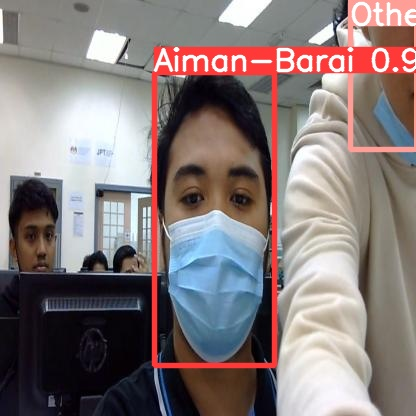

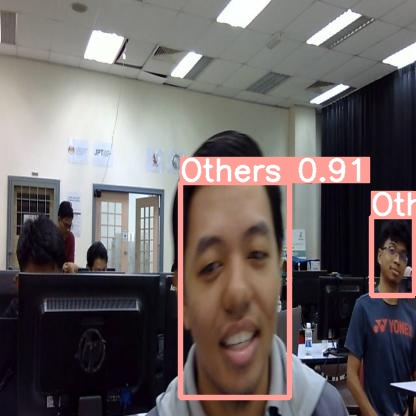

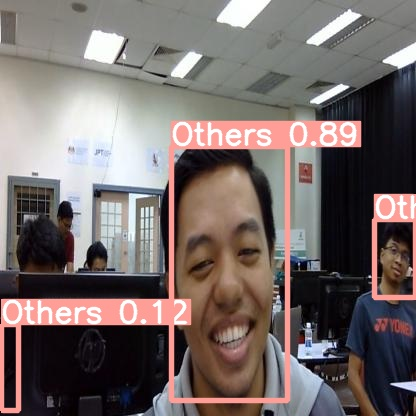

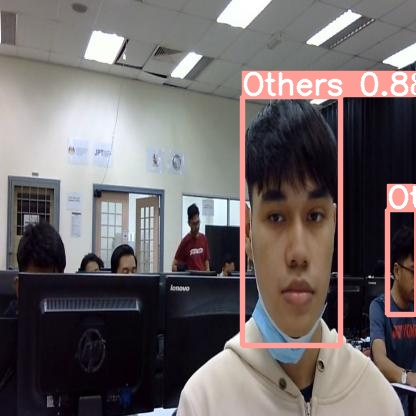

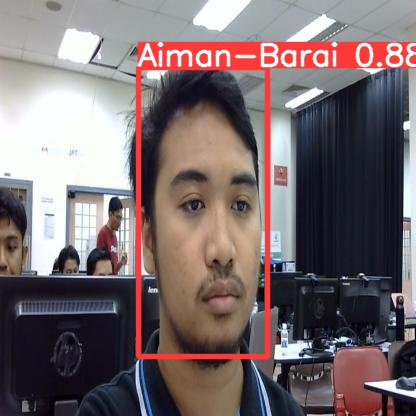

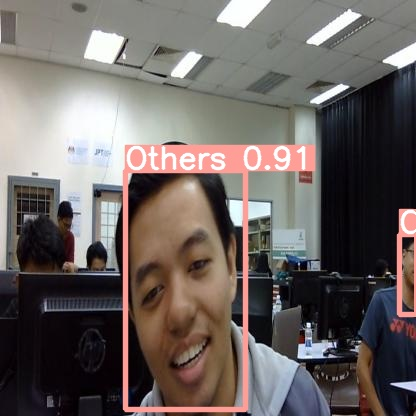

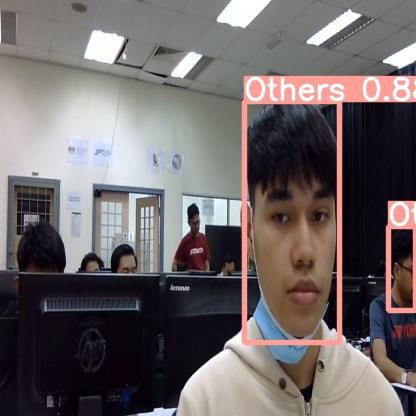

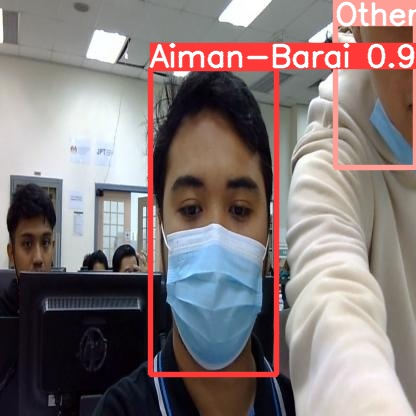

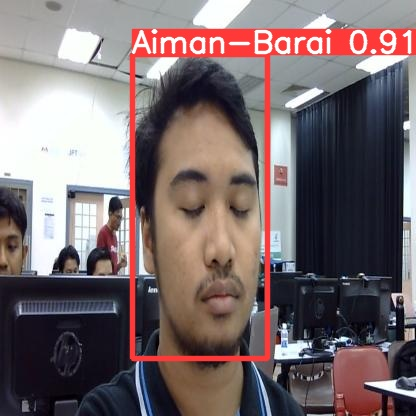

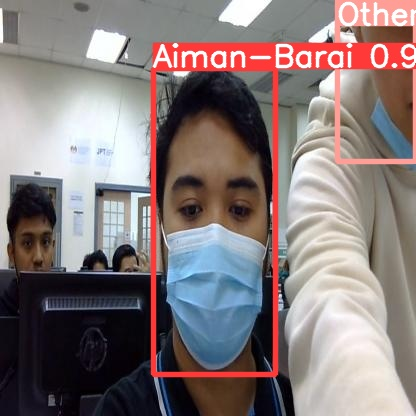

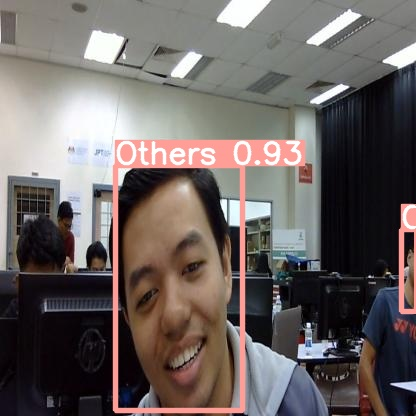

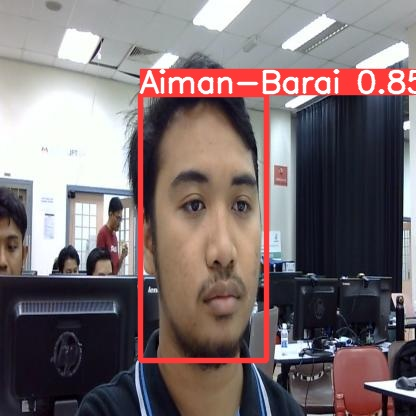

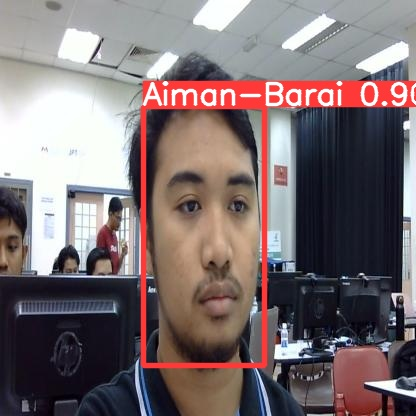

In [10]:
#display inference on ALL test images

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/yolov5/runs/detect/exp/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")


**Model & Video**
https://drive.google.com/drive/folders/1WlzDCCxrg98PmZXC85jkh26V4jTAbMVo?usp=sharing